In [2]:
from pathlib import Path

from math import floor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import jax.numpy as jnp

from jax_canveg.subjects.utils import es as fes

# from jax_canoak.shared_utilities.forcings.get_forcing import get_modis_lai
# from jax_canoak.shared_utilities.forcings.get_forcing import get_modis_et

%load_ext autoreload
%autoreload 2

In [3]:
site = "US-Bi1"
dir_flux_data = Path(f"../../data/fluxtower/{site}")
dir_modis_data = Path(f"../../data/modis/{site}")

f_forcing = (
    dir_flux_data
    / "AMF_US-Bi1_FLUXNET_FULLSET_2016-2021_3-5"
    / "AMF_US-Bi1_FLUXNET_FULLSET_HH_2016-2021_3-5.csv"
)
f_chamber = dir_flux_data / "BouldinAlfalfaForcedDiffusion2018_2021.csv"
f_modis_lai = dir_modis_data / "MCD15A3H" / "filtered_scaled_Lai_500m.csv"
f_modis_le = dir_modis_data / "MOD16A2GF" / "filtered_scaled_LE_500m.csv"

# modis_lai_scale_factor = 0.1
modis_lai_scale_factor = 1
modis_le_scale_factor = 1e4
pixel_ind = 144

# Flux tower data

In [4]:
# Read the dataframe
df = pd.read_csv(f_forcing)

In [5]:
# Get the time frame
df.index = pd.to_datetime(df["TIMESTAMP_END"], format="%Y%m%d%H%M")

In [6]:
# Vegetation height
df["veg_ht"] = 0.8

In [7]:
start, end = "2018-07-01", "2020-06-30"

/var/folders/b7/q6wyxw8x1_s5rh1mqvfb8vsr0000gn/T/ipykernel_21070/1184223325.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["RH"][df["RH"] == 0] = np.nan
/var/folders/b7/q6wyxw8x1_s5rh1mqvfb8vsr0000gn/T/ipykernel_21070/1184223325.py:5

<Axes: xlabel='TIMESTAMP_END'>

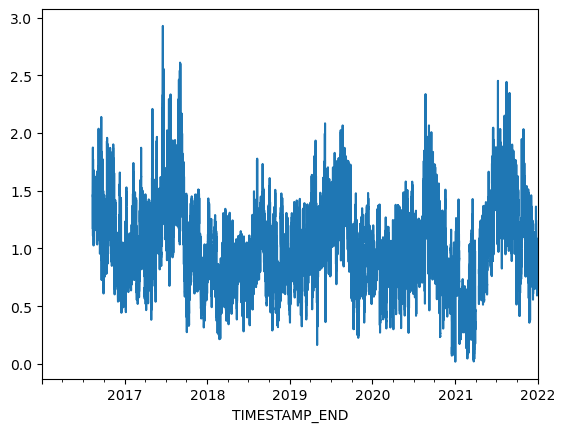

In [8]:
# Calculate vapor pressure from air temperature and relative humidity
es = fes(df["TA_F"].values + 273.15)
# ea = es - df['VPD'].values*1000
df["RH"] = np.clip(df["RH"], a_max=100, a_min=0)
df["RH"][df["RH"] == 0] = np.nan
ea = es * df["RH"].values / 100

df["eair"] = ea / 1e3  # kPa
df["eair"].plot()

# Soil respiration

In [9]:
df_soil = pd.read_csv(f_chamber)
df_soil["hour"] = df_soil["hhmm"].apply(lambda x: floor(x / 100))
df_soil["min"] = df_soil["hhmm"] - df_soil["hour"] * 100
df_soil["doy"] = df_soil["doy"].apply(lambda x: str(x).zfill(3))

In [10]:
df_soil.index = pd.to_datetime(
    df_soil["year"].astype(str).str.zfill(4)
    + df_soil["doy"].astype(str).str.zfill(3)
    + df_soil["hour"].astype(str).str.zfill(2)
    + df_soil["min"].astype(str).str.zfill(2),
    format="%Y%j%H%M",
)

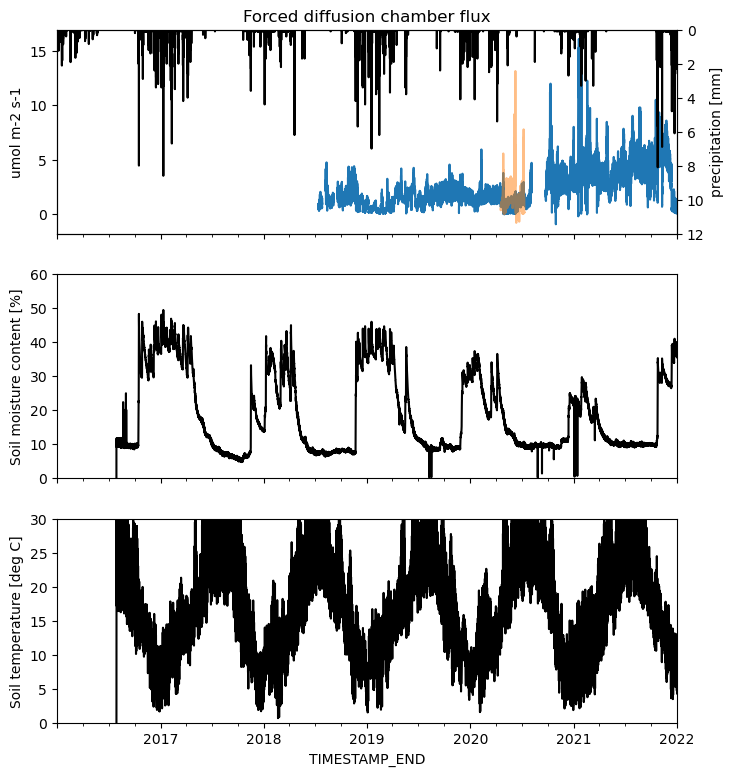

In [61]:
fig, axes = plt.subplots(3, 1, figsize=(8, 9), sharex=True)
ax = axes[0]
df_soil["BA_met f_FD_Flux"].plot(ax=ax, label="FD")
df_soil["BA_met f_FD_B_Flux"].plot(ax=ax, alpha=0.5, label="FD_B")
ax.set(
    title="Forced diffusion chamber flux",
    ylabel="umol m-2 s-1",
    # xlim=[df_soil.index[10000], df_soil.index[15000]])
    xlim=[df_soil.index[-5001], df_soil.index[-1]],
)
# ax.legend()
ax2 = ax.twinx()
df["P_F"].plot(ax=ax2, color="black", label="precip")
ax2.set(ylabel="precipitation [mm]", ylim=[12, 0])

ax = axes[1]
df["SWC_F_MDS_1"].plot(ax=ax, color="black", label="soil moisture content")
ax.set(ylabel="Soil moisture content [%]", ylim=[0, 60])

ax = axes[2]
# df['SWC_F_MDS_1'].plot(ax=ax2, color='black', label='soil moisture content')
# ax2.set(ylabel='Soil moisture content [%]', ylim=[60, 0])
# ax2.invert_yaxis()
df["TS_F_MDS_1"].plot(ax=ax, color="black", label="Soil temperature")
ax.set(ylabel="Soil temperature [deg C]", ylim=[0, 30]);

In [18]:
df_soil = df_soil[["BA_met f_FD_Flux"]]
df_soil.rename(columns={"BA_met f_FD_Flux": "Rsoil"}, inplace=True)

/var/folders/b7/q6wyxw8x1_s5rh1mqvfb8vsr0000gn/T/ipykernel_21070/1189011353.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_soil.rename(columns={"BA_met f_FD_Flux": "Rsoil"}, inplace=True)


In [51]:
# df_soil.resample("30min").ffill()

# MODIS data


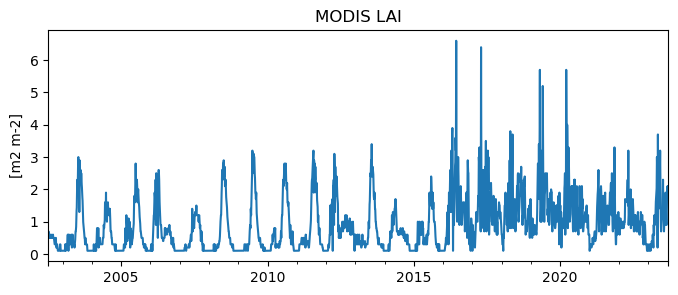

In [11]:
df_modis_lai = pd.read_csv(f_modis_lai, header=None)
df_modis_lai.index = df_modis_lai[2].apply(
    lambda x: pd.to_datetime(x[1:], format="%Y%j")
)
df_modis_lai["LAI"] = df_modis_lai[4 + pixel_ind].apply(
    lambda x: float(x) / modis_lai_scale_factor if x != "F" else np.nan
)
df_modis_lai = df_modis_lai[["LAI"]]
df_modis_lai = df_modis_lai.resample("30min").interpolate()
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
df_modis_lai["LAI"].plot(ax=ax)
ax.set(title="MODIS LAI", xlabel="", ylabel="[m2 m-2]");

<Axes: xlabel='2'>

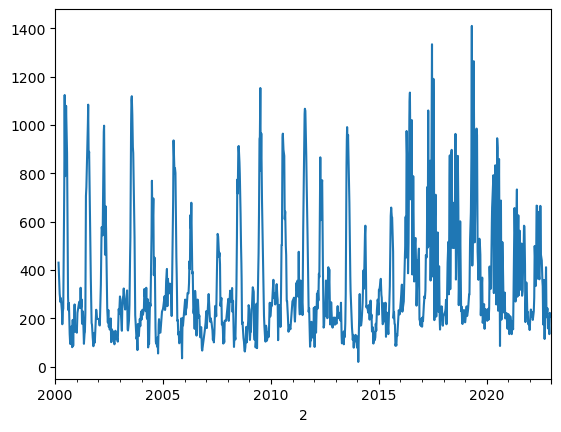

In [12]:
df_modis_le = pd.read_csv(f_modis_le, header=None)
df_modis_le.index = df_modis_le[2].apply(lambda x: pd.to_datetime(x[1:], format="%Y%j"))
df_modis_le["LE_MODIS"] = df_modis_le[4 + pixel_ind].apply(
    lambda x: float(x) / modis_le_scale_factor if x != "F" else np.nan
)
df_modis_le = df_modis_le[["LE_MODIS"]]
df_modis_le = df_modis_le.resample("30min").interpolate()
df_modis_le["LE_MODIS"].plot()

In [13]:
# df_modis = pd.concat([df_modis_lai, df_modis_le])
df_modis = df_modis_lai.join(df_modis_le)
df_modis.head()

,LAI,LE_MODIS
2,,
2002-07-04 00:00:00,0.500000,196.000000
2002-07-04 00:30:00,0.501042,195.888021
2002-07-04 01:00:00,0.502083,195.776042
2002-07-04 01:30:00,0.503125,195.664062
2002-07-04 02:00:00,0.504167,195.552083


In [18]:
# data_json['subset'][5]['data']
# Get MODIS LAI
# start, end = df.index[0], df.index[-1]
# df_modis = get_modis_lai("US-Hn1", start, end, method='mean', sample_freq="30min")
# df_modis, data_json = get_modis_lai(
#   "US-Hn1", start, end, method='mean', sample_freq="30min"
# )
# df_modis["LAI"].plot()

In [19]:
# df_modis = pd.read_csv(f_modis_lai, header=None)
# df_modis.index = df_modis[2].apply(lambda x: pd.to_datetime(x[1:], format="%Y%j"))
# df_modis["LAI"] = df_modis[6].apply(
#     lambda x: float(x) / modis_lai_scale_factor if x != "F" else np.nan
# )
# df_modis = df_modis[["LAI"]]
# df_modis = df_modis.resample("30min").interpolate()
# df_modis["LAI"].plot()

# Combine data

In [14]:
df[start:end].shape

(35088, 237)

In [20]:
df = df.join(df_modis)
df = df.join(df_soil[["Rsoil"]])
df[start:end].shape

(35088, 240)

# Forcings

In [21]:
df[df == -9999] = np.nan

In [22]:
df["Year"] = df.index.year
df["DoY"] = df.index.day_of_year
df["Hour"] = df.index.hour + df.index.minute / 60.0
df["SWC_F_MDS_1"] = df["SWC_F_MDS_1"] / 100.0

In [23]:
# list(df.keys())
df["TA_F_QC"]

TIMESTAMP_END
2016-01-01 00:30:00    2
2016-01-01 01:00:00    2
2016-01-01 01:30:00    2
2016-01-01 02:00:00    2
2016-01-01 02:30:00    2
                      ..
2021-12-31 22:00:00    0
2021-12-31 22:30:00    0
2021-12-31 23:00:00    0
2021-12-31 23:30:00    0
2022-01-01 00:00:00    0
Name: TA_F_QC, Length: 105216, dtype: int64

In [24]:
# The following information is needed to drive CANOAK
in_varns = [
    "Year",
    "DoY",
    "Hour",
    "TA_F",
    "SW_IN_F",
    "eair",
    "WS_F",
    "CO2_F_MDS",
    "PA_F",
    "USTAR",
    "TS_F_MDS_4",
    "SWC_F_MDS_1",
    "veg_ht",
    "LAI",
]

<Axes: xlabel='TIMESTAMP_END'>

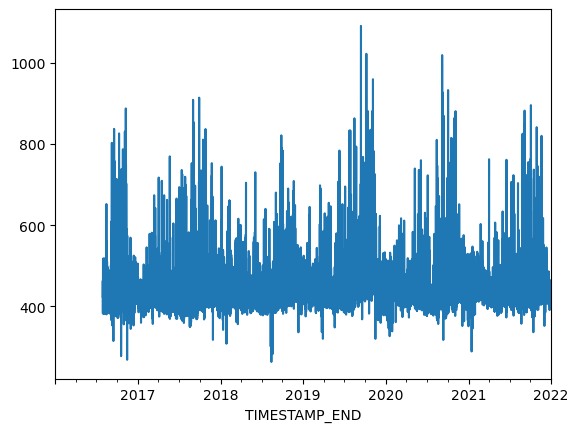

In [25]:
# Clean up the negative CO2 ppm
df.loc[df["CO2_F_MDS"] <= 100, "CO2_F_MDS"] = np.nan
df["CO2_F_MDS"].plot()

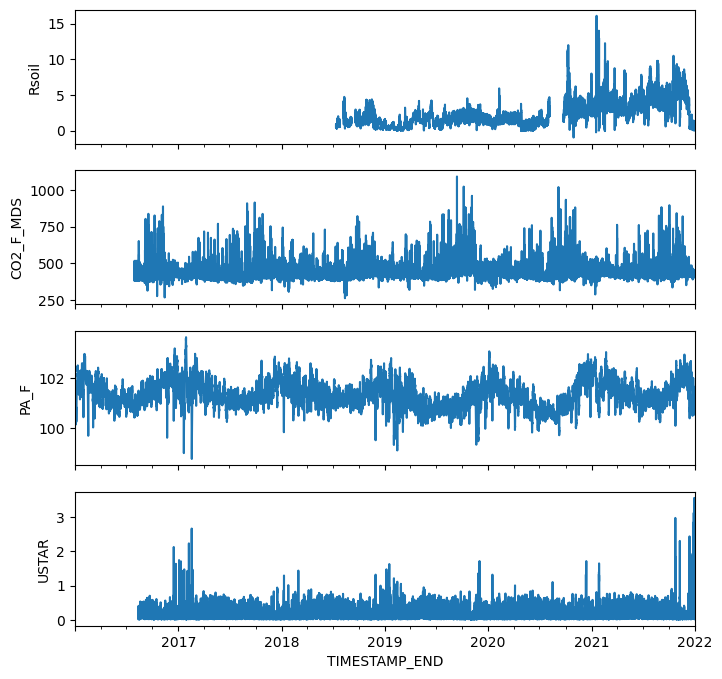

In [26]:
varns = ["Rsoil", "CO2_F_MDS", "PA_F", "USTAR"]
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 8), sharex=True)
for i, varn in enumerate(varns):
    ax = axes[i]
    df[varn].plot(ax=ax)
    ax.set(ylabel=varn)

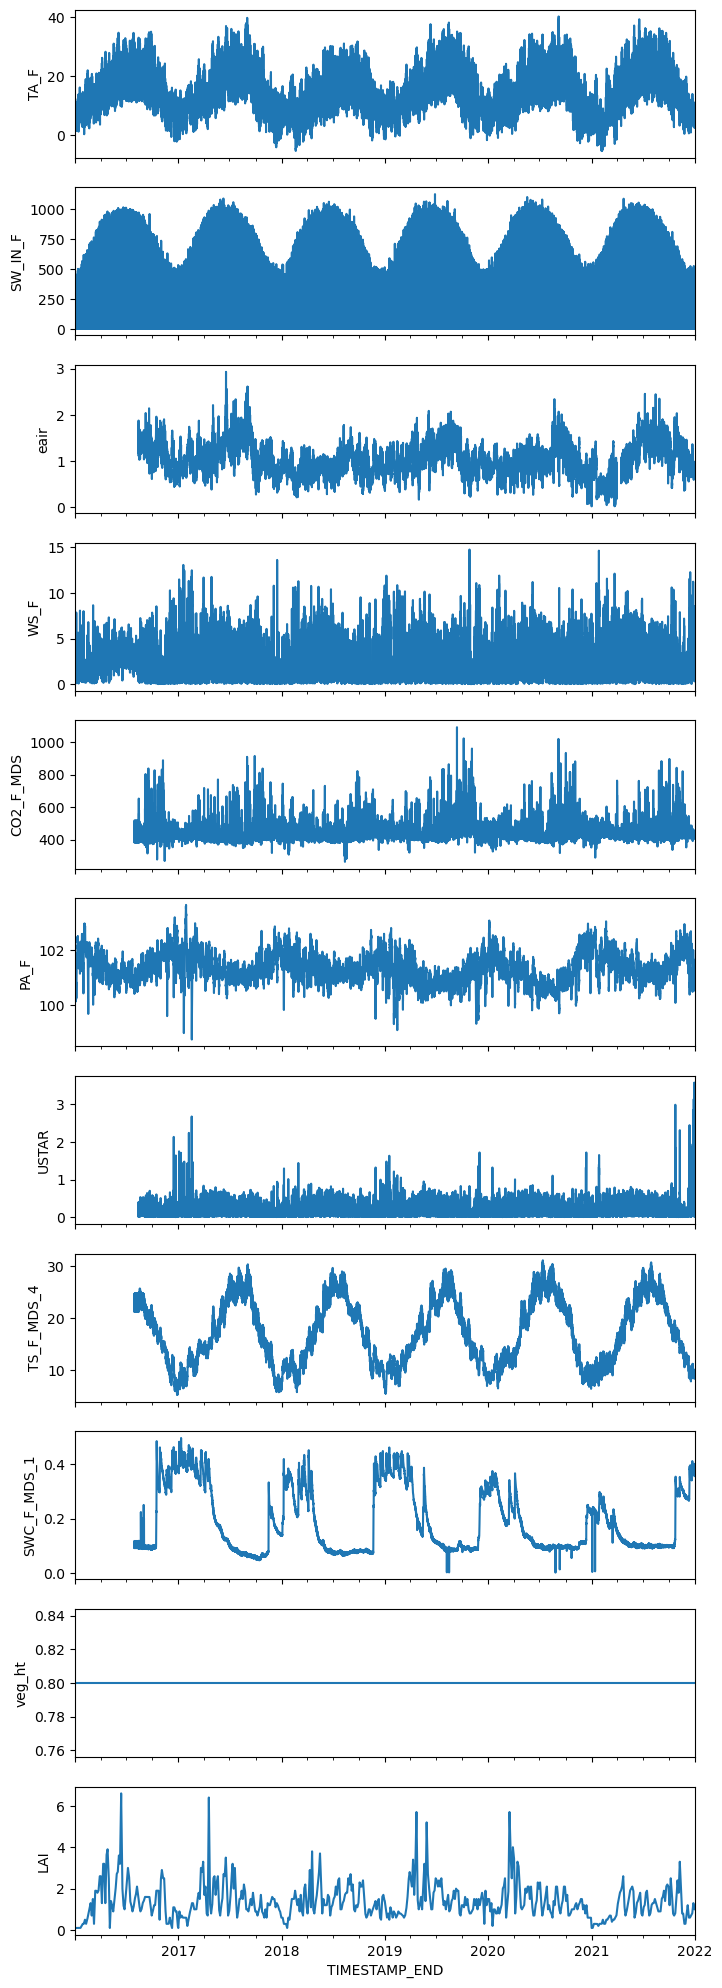

In [27]:
varns = in_varns[3:]
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 25), sharex=True)
for i, varn in enumerate(varns):
    ax = axes[i]
    df[varn].plot(ax=ax)
    ax.set(ylabel=varn)

In [29]:
df[in_varns][start:end]

,Year,DoY,Hour,TA_F,SW_IN_F,eair,WS_F,CO2_F_MDS,PA_F,USTAR,TS_F_MDS_4,SWC_F_MDS_1,veg_ht,LAI
TIMESTAMP_END,,,,,,,,,,,,,,
2018-07-01 00:00:00,2018,182,0.0,18.40,0.0,0.809921,6.980,411.565,100.88,0.562560,28.603,0.07300,0.8,1.275000
2018-07-01 00:30:00,2018,182,0.5,18.12,0.0,0.838017,6.329,408.403,100.88,0.532901,28.457,0.07267,0.8,1.276563
2018-07-01 01:00:00,2018,182,1.0,17.32,0.0,0.885383,5.103,411.128,100.89,0.428350,28.320,0.07233,0.8,1.278125
2018-07-01 01:30:00,2018,182,1.5,16.53,0.0,0.907755,4.551,411.178,100.89,0.366572,28.183,0.07200,0.8,1.279687
2018-07-01 02:00:00,2018,182,2.0,15.90,0.0,0.909415,4.984,410.198,100.91,0.452048,28.043,0.07200,0.8,1.281250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30 21:30:00,2020,182,21.5,16.62,0.0,1.135860,1.591,462.684,100.43,0.092686,26.867,0.09733,0.8,2.142187
2020-06-30 22:00:00,2020,182,22.0,16.84,0.0,1.145312,1.345,445.602,100.40,0.039062,26.713,0.09667,0.8,2.143750
2020-06-30 22:30:00,2020,182,22.5,15.16,0.0,1.075007,0.962,475.210,100.39,0.135450,26.573,0.09633,0.8,2.145312


In [30]:
# Save the forcing data
# start, end = "2016-06-01", "2017-06-30"
start, end = "2018-07-01", "2020-06-30"
# start, end = "2018-12-01", "2019-12-30"
# start, end = "2018-12-01", "2018-12-30"
df_save = df[in_varns][start:end]
df_save.interpolate(inplace=True)
# np.savetxt(dir_flux_data / "US-Bi1-forcings-short.csv", df_save.values, delimiter=",")
df_save.to_csv(dir_flux_data / "US-Bi1-forcings.csv", sep=",")

# Save the forcing data to be loaded in CanVeg-matlab
np.savetxt(dir_flux_data / "US-Bi1-forcings.txt", df_save.values, delimiter=",")

In [31]:
# Save the forcing data -- test
start_test, end_test = "2020-07-01", "2021-12-30"
df_save = df[in_varns][start_test:end_test]
df_save.interpolate(inplace=True)
df_save.to_csv(dir_flux_data / "US-Bi1-forcings-test.csv", sep=",")

# Save the forcing data to be loaded in CanVeg-matlab
np.savetxt(dir_flux_data / "US-Bi1-forcings-test.txt", df_save.values, delimiter=",")

# Responses/fluxes

In [41]:
# df_soil["Rsoil"]["2019-05-27":"2019-05-28"].sort_index()

In [42]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 3))
# # df_soil['Rsoil']['2019-05-27':'2019-06-06'].plot(ax=ax)
# df_soil["Rsoil"]["2019-05-27":"2019-05-28"].plot(ax=ax)
# ax.set(ylabel="[umol m-2 s-1]", title="FD")

In [43]:
# df["Rsoil"].iloc[101000:101500]

In [44]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 3))
# df["Rsoil"].iloc[101000:101500].plot(ax=ax)
# ax.set(ylabel="[umol m-2 s-1]", title="FD")

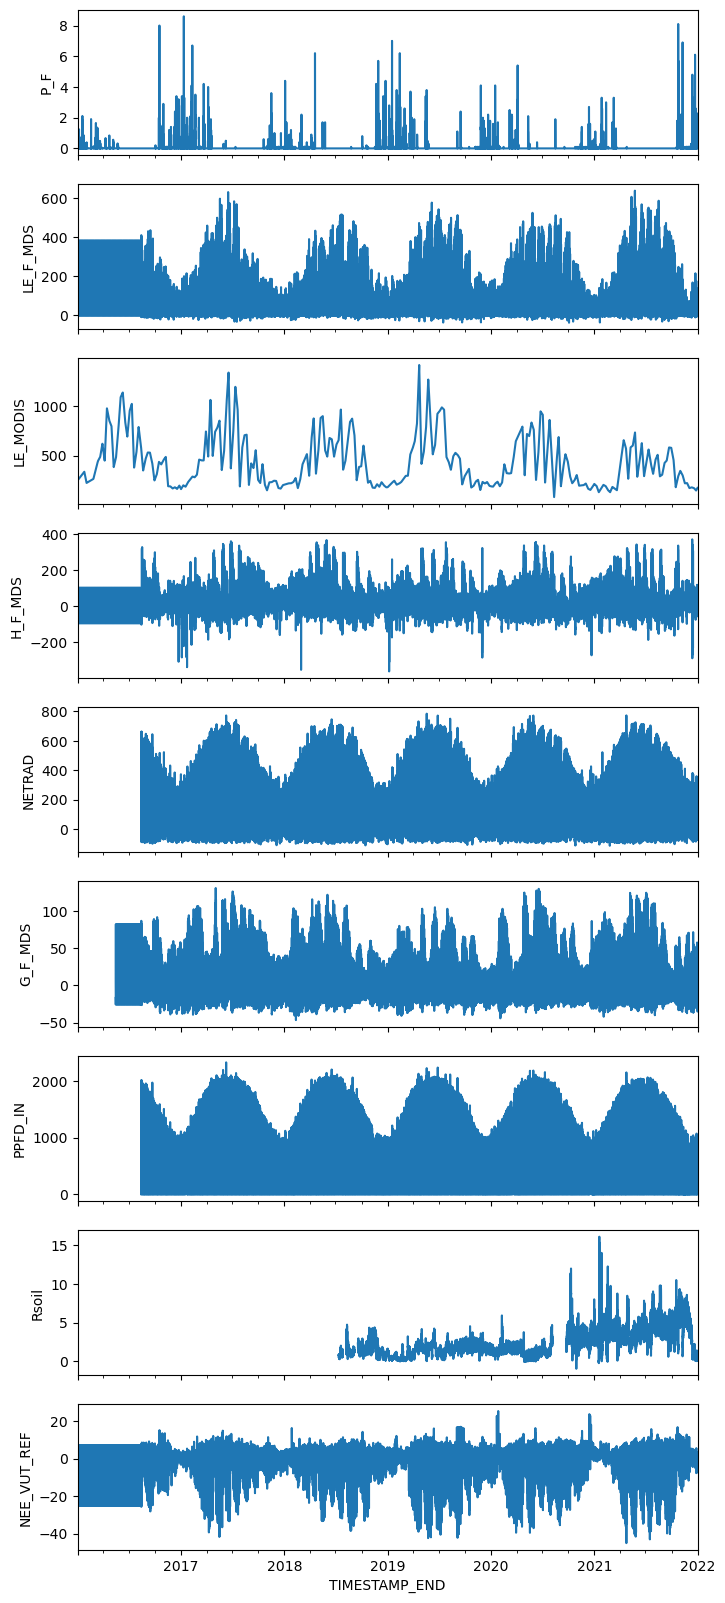

In [33]:
# The data to compare
out_varns = [
    "P_F",
    "LE_F_MDS",
    "LE_MODIS",
    "H_F_MDS",
    "NETRAD",
    "G_F_MDS",
    "PPFD_IN",
    "Rsoil",
    "NEE_VUT_REF",
]
varns = out_varns
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 20), sharex=True)
for i, varn in enumerate(varns):
    ax = axes[i]
    df[varn].plot(ax=ax)
    ax.set(ylabel=varn)

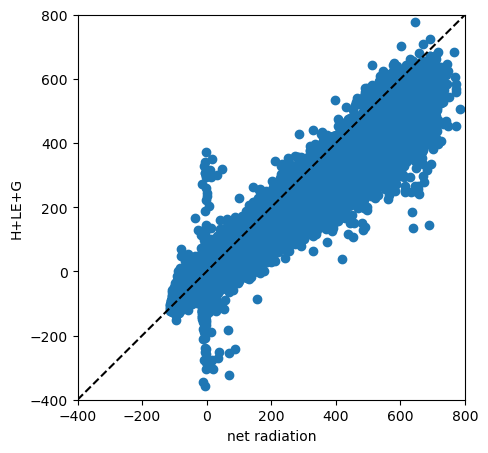

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
lim = [-400, 800]
ax.scatter(df["NETRAD"], df["H_F_MDS"] + df["LE_F_MDS"] + df["G_F_MDS"])
ax.plot(lim, lim, "k--")
ax.set(xlim=lim, ylim=lim, xlabel="net radiation", ylabel="H+LE+G");

In [35]:
df[out_varns][start:end].interpolate()

,P_F,LE_F_MDS,LE_MODIS,H_F_MDS,NETRAD,G_F_MDS,PPFD_IN,Rsoil,NEE_VUT_REF
TIMESTAMP_END,,,,,,,,,
2018-07-01 00:00:00,0.0,22.858000,565.375000,-71.697800,-79.809506,-17.1945,0.0,NaN,7.03372
2018-07-01 00:30:00,0.0,20.460900,565.684896,-69.562800,-78.913358,-17.3367,0.0,NaN,5.04694
2018-07-01 01:00:00,0.0,13.716400,565.994792,-49.388900,-77.391746,-17.4957,0.0,NaN,4.04786
2018-07-01 01:30:00,0.0,10.714000,566.304688,-36.743700,-75.324140,-17.6424,0.0,NaN,3.35383
2018-07-01 02:00:00,0.0,16.067800,566.614583,-52.042100,-74.263393,-18.4790,0.0,NaN,4.76135
...,...,...,...,...,...,...,...,...,...
2020-06-30 21:30:00,0.0,1.305120,920.679688,-0.365430,-56.488750,-24.9236,0.0,1.14,6.11123
2020-06-30 22:00:00,0.0,-0.604463,920.593750,-3.352810,-53.988869,-25.7750,0.0,1.24,6.18899
2020-06-30 22:30:00,0.0,14.821500,920.507812,-6.683590,-54.961173,-26.6158,0.0,1.19,6.04496


In [36]:
# Save the data to compare
df_save = df[out_varns][start:end]
df_save.interpolate(inplace=True)
# np.savetxt('US-Hn1-fluxes.csv', df_save.values, delimiter=',')
# df_save.to_csv(dir_flux_data / "US-Bi1-fluxes-short.csv", sep=",")
df_save.to_csv(dir_flux_data / "US-Bi1-fluxes.csv", sep=",")

In [37]:
# Save the data to compare -- test
df_save = df[out_varns][start_test:end_test]
df_save.interpolate(inplace=True)
# np.savetxt('US-Hn1-fluxes.csv', df_save.values, delimiter=',')
# df_save.to_csv(dir_flux_data / "US-Bi1-fluxes-short.csv", sep=",")
df_save.to_csv(dir_flux_data / "US-Bi1-fluxes-test.csv", sep=",")